In [7]:
# import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense


In [2]:
%cd "D:\CNN\op"

D:\CNN\op


In [3]:
class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [4]:
# Define the ImageDataGenerator for training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Define the ImageDataGenerator for test data (no validation split)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Set the target size, batch size, and class mode
target_size = (50, 50)
batch_size = 32
class_mode = 'categorical'

# Training data generator with validation split
train_generator = train_datagen.flow_from_directory(
    'Train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    subset='training'  # Subset for training data
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    'Train',
    target_size=target_size,
    batch_size=16,
    class_mode=class_mode,
    subset='validation'  # Subset for validation data
)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    'Test',
    target_size=target_size,
    batch_size=16,
    class_mode=class_mode,
    shuffle=False  # Disable shuffling for test data
)

Found 206 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


In [5]:

X_train, y_train = train_generator.next()

model = Sequential()

# Add a convolutional layer with 16 filters, a 5x5 kernel size, and ReLU activation
model.add(Conv2D(16, (5, 5),padding="same", input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer with the same settings as before
model.add(Conv2D(16, (5, 5),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer with the same settings as before
model.add(Conv2D(64, (5, 5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the convolutional layer
model.add(Flatten())


# Add a fully connected (dense) layer with 1000 neurons and ReLU activation, followed by dropout
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))

# Add a fully connected (dense) layer with 1000 neurons and ReLU activation, followed by dropout
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

# Add a fully connected (dense) layer with 1000 neurons and ReLU activation, followed by dropout
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))

# Add a fully connected (dense) layer with 1000 neurons and ReLU activation, followed by dropout
model.add(Dense(125, activation='relu'))
model.add(Dropout(0.5))

# Add another fully connected layer with 128 neurons and ReLU activation, followed by batch normalization
model.add(Dense(60, activation='relu'))
model.add(BatchNormalization())

# Add an output layer with 10 neurons and softmax activation for multi-class classification
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
callbacks_list = [PlotLearning()]

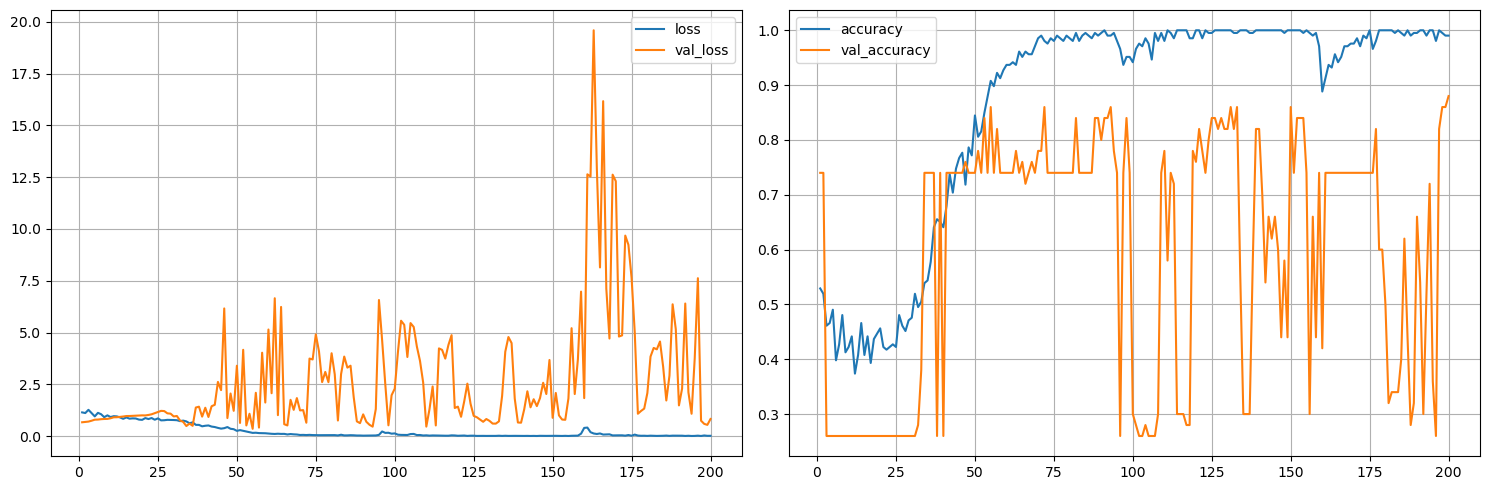

7/7 [==============================] - 1s 189ms/step - loss: 0.0133 - accuracy: 0.9903 - val_loss: 0.8251 - val_accuracy: 0.8800


In [8]:
## fit the model

# compute class weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes = np.unique(y_train),
                                                  y = np.argmax(y_train, axis=1))

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))
model.fit(train_generator,
          epochs=200,
         shuffle=True,
          class_weight=class_weights_dict,
          callbacks=callbacks_list,
         validation_data=validation_generator)
   # validation_steps=validation_generator.samples // batch_size,)

In [10]:
## fetch test data 
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    'Test',
    target_size=(50, 50),
    batch_size=8,
    class_mode='categorical'
)

# Use the model to generate predictions on the test data
predictions = model.predict(test_generator)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_generator.classes

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))

Found 46 images belonging to 2 classes.
6/6 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

           0       0.73      0.97      0.83        33
           1       0.50      0.08      0.13        13

    accuracy                           0.72        46
   macro avg       0.61      0.52      0.48        46
weighted avg       0.66      0.72      0.63        46

